File loaded successfully: /content/drive/MyDrive/master.csv

--- Preview of Raw Dataset ---
   country  year     sex          age  suicides_no  population  \
0  Albania  1987    male  15-24 years           21      312900   
1  Albania  1987    male  35-54 years           16      308000   
2  Albania  1987  female  15-24 years           14      289700   
3  Albania  1987    male    75+ years            1       21800   
4  Albania  1987    male  25-34 years            9      274300   

   suicides/100k pop country-year  HDI for year  gdp_for_year ($)   \
0               6.71  Albania1987           NaN      2,156,624,900   
1               5.19  Albania1987           NaN      2,156,624,900   
2               4.83  Albania1987           NaN      2,156,624,900   
3               4.59  Albania1987           NaN      2,156,624,900   
4               3.28  Albania1987           NaN      2,156,624,900   

   gdp_per_capita ($)       generation  
0                 796     Generation X  
1       

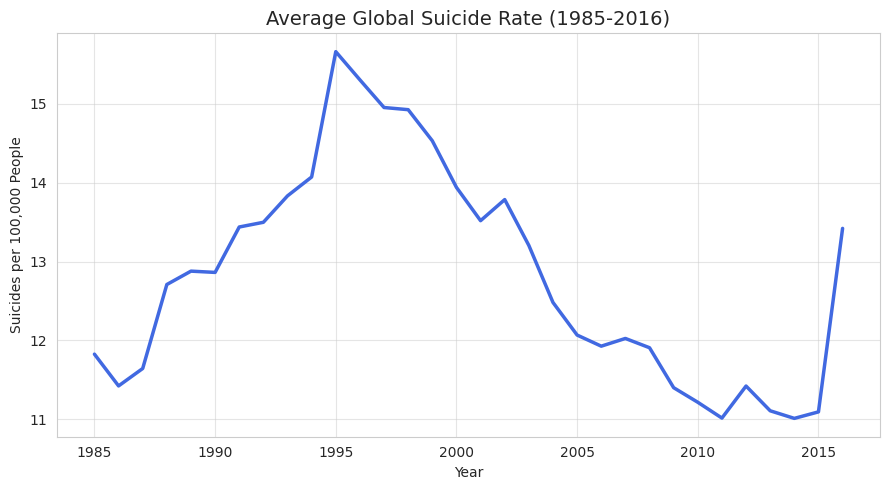

/tmp/ipython-input-3599511524.py:162: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


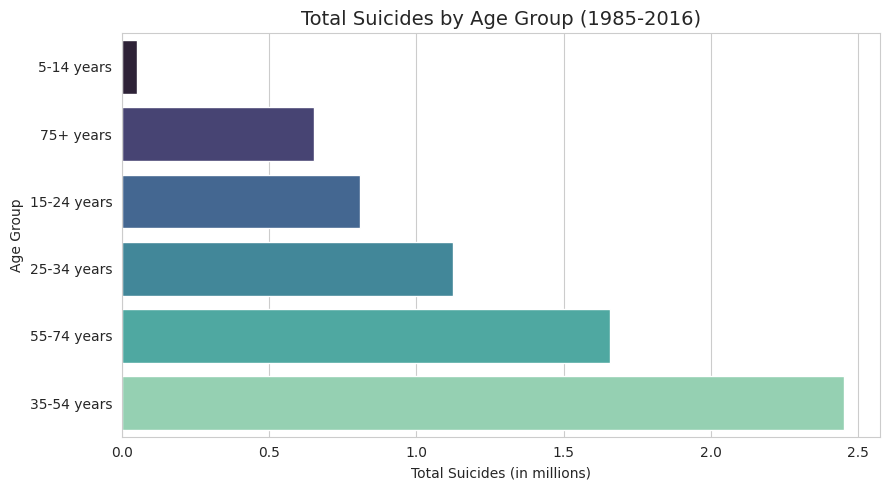

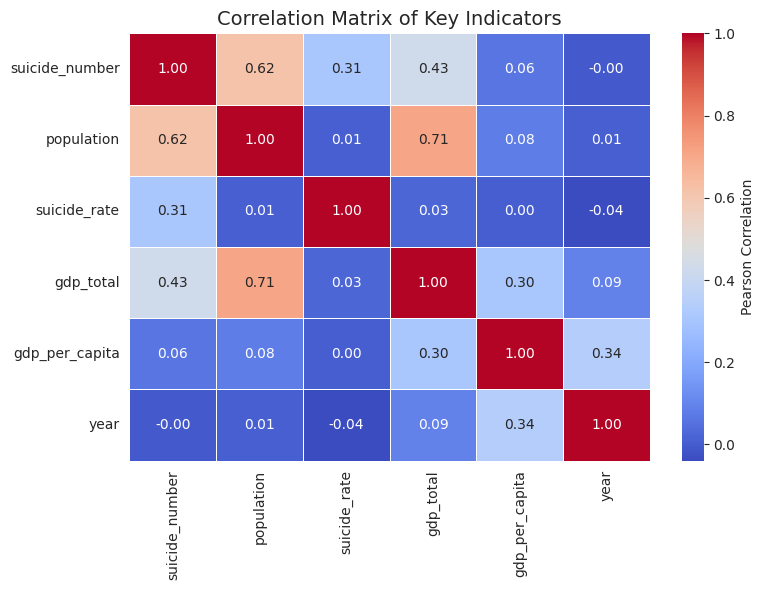

In [2]:

# ---------------------------------------------------------------
# Suicide Data Analysis (Clean and Human-Readable Version)
# ---------------------------------------------------------------

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import StatisticsError

# ---------------------------------------------------------------
# Step 1: Load the dataset
# ---------------------------------------------------------------

DATA_FILE = "/content/drive/MyDrive/master.csv"

def load_csv_data(file_path: str) -> pd.DataFrame:
    """Load a CSV file into a pandas DataFrame."""
    try:
        df = pd.read_csv(file_path)
        print(f"File loaded successfully: {file_path}")
        return df
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return pd.DataFrame()

# Load the dataset
dataset = load_csv_data(DATA_FILE)

if dataset.empty:
    raise SystemExit("No dataset found. Process terminated.")

print("\n--- Preview of Raw Dataset ---")
print(dataset.head())


# ---------------------------------------------------------------
# Step 2: Clean and prepare the data
# ---------------------------------------------------------------

def clean_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """Clean and prepare the dataset for analysis."""
    print("\nStarting data cleaning...")

    # Rename inconsistent column names
    rename_dict = {
        'suicides/100k pop': 'suicide_rate',
        ' gdp_for_year ($) ': 'gdp_total',
        'gdp_per_capita ($)': 'gdp_per_capita',
        'country': 'country',
        'sex': 'gender',
        'age': 'age_group',
        'year': 'year',
        'suicides_no': 'suicide_number',
        'population': 'population',
        'generation': 'generation'
    }

    df = df.rename(columns=rename_dict)

    # Drop unnecessary or empty columns
    df = df.drop(columns=['HDI for year', 'country-year'], errors='ignore')

    # Clean GDP formatting (remove commas and convert to float)
    df['gdp_total'] = (
        df['gdp_total']
        .astype(str)
        .str.replace(',', '', regex=False)
        .astype(float)
    )

    print("Data cleaning completed.")
    return df


# Apply cleaning
clean_data = clean_dataset(dataset)

print("\n--- Dataset After Cleaning ---")
print(clean_data.head())


# ---------------------------------------------------------------
# Step 3: Generate statistical summaries
# ---------------------------------------------------------------

def statistical_summary(column: pd.Series, title: str):
    """Print basic statistics for a numerical column."""
    print(f"\nSummary for: {title}")
    stats = column.describe()

    try:
        mode_values = column.mode()
        if mode_values.empty:
            mode_text = "No mode"
        elif len(mode_values) == 1:
            mode_text = f"{mode_values.iloc[0]:.2f}"
        else:
            mode_text = ", ".join([f"{val:.2f}" for val in mode_values[:3]])
    except StatisticsError:
        mode_text = "Undefined"

    print(f"Mean: {stats['mean']:.3f}")
    print(f"Median: {stats['50%']:.3f}")
    print(f"Mode: {mode_text}")
    print(f"Standard Deviation: {stats['std']:.3f}")
    print(f"Min: {stats['min']:.3f} | Max: {stats['max']:.3f}")
    print(f"Range: {(stats['max'] - stats['min']):.3f}")


# Display stats
statistical_summary(clean_data['suicide_rate'], "Suicide Rate (per 100k)")
statistical_summary(clean_data['gdp_per_capita'], "GDP per Capita (USD)")


# ---------------------------------------------------------------
# Step 4: Data Visualization
# ---------------------------------------------------------------

sns.set_style("whitegrid")
sns.set_palette("flare")


# ---- 4.1 Global Trend Over Time ----
def plot_trend(df: pd.DataFrame):
    """Show the average suicide rate for each year."""
    yearly_data = (
        df.groupby('year', as_index=False)['suicide_rate']
        .mean()
        .rename(columns={'suicide_rate': 'avg_rate'})
    )

    plt.figure(figsize=(9, 5))
    sns.lineplot(
        data=yearly_data,
        x='year',
        y='avg_rate',
        color='royalblue',
        linewidth=2.5
    )
    plt.title("Average Global Suicide Rate (1985-2016)", fontsize=14)
    plt.xlabel("Year")
    plt.ylabel("Suicides per 100,000 People")
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()


plot_trend(clean_data)


# ---- 4.2 Suicides by Age Group ----
def plot_agewise_suicides(df: pd.DataFrame):
    """Show total suicides by age category."""
    plt.figure(figsize=(9, 5))
    age_summary = (
        df.groupby('age_group', as_index=False)['suicide_number']
        .sum()
        .assign(total_millions=lambda x: x['suicide_number'] / 1_000_000)
    )

    sns.barplot(
        data=age_summary.sort_values('total_millions', ascending=True),
        y='age_group',
        x='total_millions',
        palette='mako'
    )

    plt.title("Total Suicides by Age Group (1985-2016)", fontsize=14)
    plt.xlabel("Total Suicides (in millions)")
    plt.ylabel("Age Group")
    plt.tight_layout()
    plt.show()


plot_agewise_suicides(clean_data)


# ---- 4.3 Correlation Matrix ----
def display_correlation(df: pd.DataFrame):
    """Display correlation coefficients between key numerical features."""
    numeric_cols = ['suicide_number', 'population', 'suicide_rate',
                    'gdp_total', 'gdp_per_capita', 'year']
    correlation_values = df[numeric_cols].corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        correlation_values,
        annot=True,
        cmap='coolwarm',
        fmt='.2f',
        linewidths=0.4,
        cbar_kws={'label': 'Pearson Correlation'}
    )
    plt.title("Correlation Matrix of Key Indicators", fontsize=14)
    plt.tight_layout()
    plt.show()


display_correlation(clean_data)
